# Предсказание оттока клиентов в фитнес-центре

Целью настоящего исследования является разработка плана по удержанию клиентов сети фитнес-центров «Культурист-датасаентист». Путём анализа клиентских анкет планируется решить следующие задачи:
1. Научиться прогнозировать вероятность оттока на уровне следующего месяца для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Прогнозирование-оттока-клиентов" data-toc-modified-id="Прогнозирование-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Прогнозирование оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Загрузка данных

In [1]:
# загрузка библиотек
%pip install scikit-learn==0.22.1

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.0 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# чтение файла
try:
    df = pd.read_csv('gym_churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [3]:
# выведем краткую сводку и случайные 5 строк датафрейма
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2947,1,0,0,0,1,6,1,27,321.281835,6.0,1,0.604105,0.636360,0
1415,1,0,1,1,1,1,1,31,352.569017,1.0,4,1.006192,0.860990,0
3378,1,1,0,0,0,1,1,32,179.238026,1.0,10,2.873329,2.913151,0
3150,1,1,0,0,1,1,0,26,13.818039,1.0,4,2.617373,2.609531,0
3011,0,0,1,0,1,1,0,29,46.929359,1.0,3,1.777541,1.773045,0


В датасете содержатся следующие сведения о клиентах: 
- пол; 
- факт проживания или работы поблизости с фитнес-центром; 
- наличие корпоративного абонемента; 
- факт первоначальной записи в рамках акции «Приведи друга»; 
- наличие контактного телефона;
- длительность текущего абонемента;
- факт посещения групповых занятий;
- возраст;
- суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
- срок до окончания действующего абонемента;
- время с момента первого посещения фитнес-центра в месяцах;
- средняя частота посещений в неделю за все время с начала действия абонемента;
- средняя частота посещений в неделю за предыдущий месяц;
- факт оттока в текущем месяце.

Категориальные значения переведены в числовые, пропущенных значений нет. Проверим наличие дубликатов:

In [4]:
df.duplicated().sum()

0

Среди 4000 клиентских анкет повторов не обнаружено. Теперь можно изучить данные поподробнее.

In [5]:
# переведём названия столбцов в нижний регистр для удобства
df.columns = df.columns.str.lower()

## Исследовательский анализ данных

In [6]:
# выведем статистическую сводку по таблице
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Первый взгляд на статистику позволяет сделать следующие выводы о наборе данных: 
1. По признаку половой принадлежности клиенты в выборке распределены примерно поровну;
2. 85% клиентов живут или работают поблизости от фитнес-центра;
3. 49% имеют корпоративные абонементы, 51% стандартные;
4. 31% пришли по программе "Приведи друга";
5. 90% клиентов оставили свой контактный телефон;
6. Больше половины имеют действующий абонемент сроком 1 месяц;
7. Самый "старый" клиент в выборке пользуется услугами центра больше двух с половиной лет, в среднем время жизни составляет 3-4 месяца;
10. В среднем клиент посещает зал два раза в неделю, самые спортивные занимаются шесть раз в неделю;
7. 41% посещают групповые занятия;
8. Возраст клиентов - от 18 до 41 года, средний возраст 29 лет;
9. Один клиент приносит в среднем 136-146 у.е. за весь период пользования дополнительными услугами; 
12. 73,5% клиентов в выборке являются действующими, 26,5% перестали посещать центр.

Сгруппируем данные по признаку оттока и сравним показатели.

In [7]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Для категориальных признаков, закодированных значениями 1 и 0, среднее арифметическое по столбцу равняется доле пользователей, имеющих значение 1, что отражено в таблице выше. Для числовых признаков дополнительно построим графики, чтобы наглядно увидеть распределения значений.

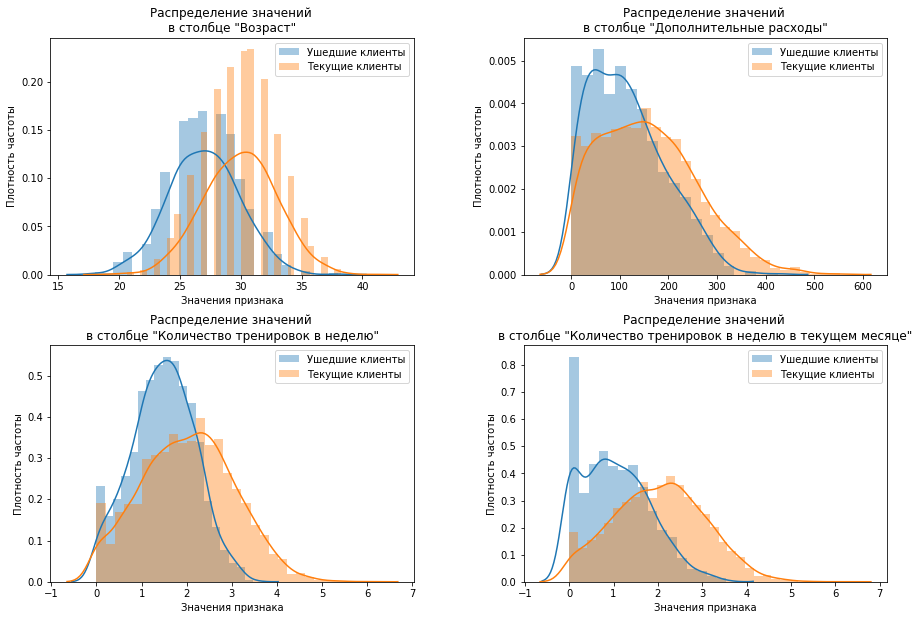

In [8]:
fig = plt.figure(figsize=(15, 10))
name = ['Возраст', 'Дополнительные расходы', 'Количество тренировок в неделю', 'Количество тренировок в неделю в текущем месяце']
for i, col in enumerate(['age', 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']):
    ax = fig.add_subplot(2, 2, i+1)
    sns.distplot(df.loc[df['churn'] == 1, col], ax=ax)
    sns.distplot(df.loc[df['churn'] == 0, col], ax=ax)
    ax.set_title('Распределение значений \nв столбце "{}"'.format(name[i]))
    ax.set_xlabel('Значения признака')
    ax.set_ylabel('Плотность частоты')
    plt.legend(['Ушедшие клиенты', 'Текущие клиенты'])
plt.subplots_adjust(wspace=0.3, hspace=0.3);

Что можно сказать о пользователях, которые перестали посещать фитнес-центр?
1. Ушедшие клиенты в среднем моложе, чем текущие (25-27 лет против 30), возможно, услуги данной сети более привлекательны для взрослой аудитории;
2. Половая принадлежность не оказывает никакого влияния на факт оттока;
3. Среди ушедших было на 10% больше клиентов, которые ездили в центр издалека, что могло повлиять на решение бросить занятия;
2. Только 36% из ушедших клиентов имели корпоративные абонементы (против 54% текущих клиентов): когда компания компенсирует стоимость занятий спортом, люди охотнее ходят в зал, чем когда приходится платить полную цену из собственного кармана;
3. Среди ушедших в два раза меньше людей пришло по акции "Приведи друга": заниматься с кем-то из знакомых веселее, чем в одиночку;
4. Ушедшие чаще приобретали краткосрочные абонементы: средний срок 1,7 месяца, тогда как у действующих клиентов он составляет 5,7 месяцев;
5. Ушедшие на 20% реже посещали групповые занятия и в целом реже ходили в зал. Особенно это заметно в последнем месяце перед уходом - частота посещений падает до 1 раза в неделю, либо клиент вообще перестает приходить.

Посмотрим, как признаки связаны между собой.

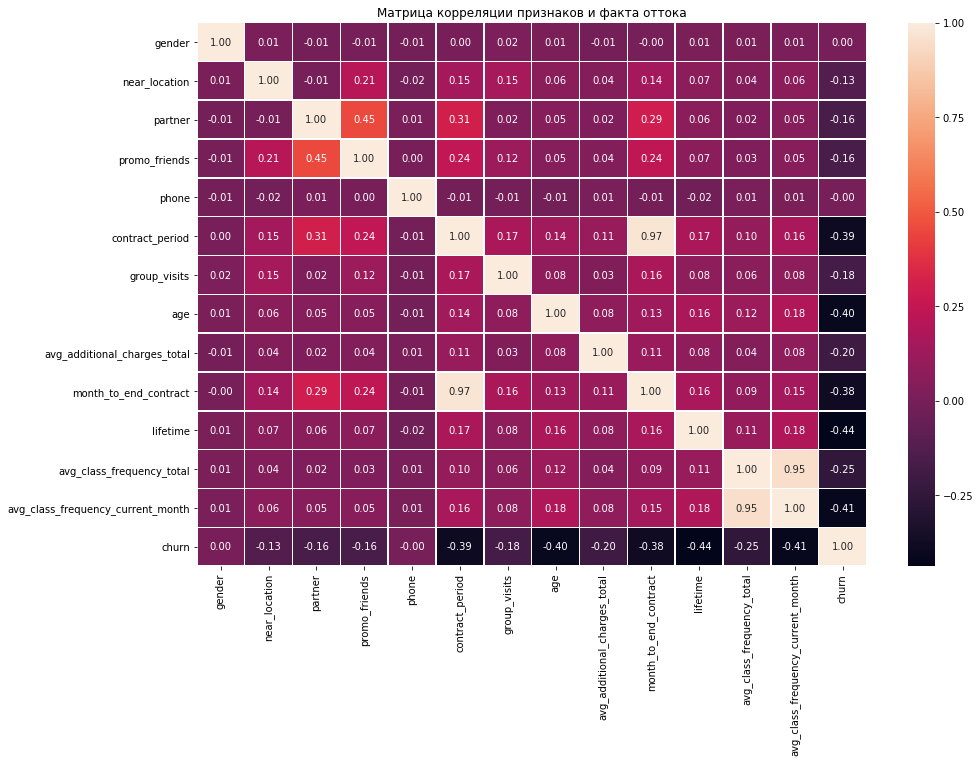

In [9]:
#построим и отрисуем матрицу корреляций
fig = plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt ='.2f', linewidths=.5, linecolor='white')
plt.title('Матрица корреляции признаков и факта оттока');

Матрица корреляций подтверждает предыдущие предположения: целевой признак не связан с полом клиента, отрицательно коррелирует с удобством расположения, наличием корпоративного абонемента и участием в реферальной программе. Сильнее всего с оттоком связаны возраст клиента (чем он моложе, тем больше вероятность ухода), активность посещений в последний месяц (если человек внезапно перестал ходить, скорее всего, он уже не вернется) и длительность абонемента (контракт на 1 или 3 месяца после завершения часто не продляют). Также видно, что признаки "длительность абонемента" и "число месяцев до конца абонемента" очень сильно коррелируют между собой, как и среднее количество тренировок - за всё время и на текущий месяц. Эти признаки являются мультиколлинеарными и могут вызвать переобучение будущей модели, поэтому мы вручную избавимся от одного признака из каждой пары.

In [10]:
df = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis = 1)

Теперь можно переходить к обучению модели.

## Прогнозирование оттока клиентов

Поскольку наш целевой признак — факт оттока клиента в следующем месяце, нам понадобится модель бинарной классификации. Реализовать её попробуем двумя способами: логистической регрессией и случайным лесом, а потом сравним, какая из моделей работает лучше.

In [11]:
#разделим датасет на признаки (матрица X) и целевую переменную (вектор y)
X = df.drop(columns='churn')
y = df['churn']

# случайным образом разделим выборки на обучающую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test)

# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

# обучим модель логистической регрессии и сделаем прогнозы
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)
print('')

# обучим модель на основе алгоритма случайного леса и сделаем прогнозы
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75
	F1: 0.78
	ROC_AUC: 0.95


Мы видим, что обе модели показали достаточно хорошие результаты. Доля правильных ответов (accuracy) одинакова и составляет 90%, точность предсказаний в целевом классе (precision) выше у алгоритма случайного леса, полнота обнаружения объектов целевого класса (recall) выше у логистической регрессии, сводные метрики F1-score и ROC_AUC также выше у модели логистической регрессии. В зависимости от целей можно использовать любой из алгоритмов: для удержания как можно большего числа клиентов модель регрессии подходит лучше, однако если компания опасается раздражать клиентов агрессивным маркетингом и ценит точность предсказаний, следует использовать случайный лес.

In [12]:
# создадим и выведем датафрейм с именами и весами признаков логистической регрессии
lr_features = pd.DataFrame({'feature' : list(X_train.columns), 'coeff' : abs(lr_model.coef_[0])})
lr_features.sort_values('coeff', ascending=False)

,feature,coeff
9,lifetime,3.922703
5,contract_period,1.340862
10,avg_class_frequency_current_month,1.326734
7,age,1.102478
8,avg_additional_charges_total,0.582020
6,group_visits,0.378909
3,promo_friends,0.244437
4,phone,0.088119
1,near_location,0.083076
2,partner,0.069225


Для модели логистической регрессии наиболее важными признаками, связанными с оттоком, являются "срок жизни" клиента, длительность абонемента, среднее количество посещений фитнес-центра в текущем месяце, возраст и сумма дополнительных расходов. Наименьшее влияние на отток, по логике данной модели, оказывают пол, корпоративные скидки и удобство расположения.

In [13]:
# создадим и выведем датафрейм с именами признаков и их важностью для модели случайного леса
rf_features = pd.DataFrame(data={'feature': X.columns, 'importance': rf_model.feature_importances_})
rf_features.sort_values('importance', ascending=False)

,feature,importance
9,lifetime,0.321261
10,avg_class_frequency_current_month,0.216309
7,age,0.138439
8,avg_additional_charges_total,0.123375
5,contract_period,0.110949
6,group_visits,0.020262
0,gender,0.016636
2,partner,0.016403
3,promo_friends,0.016031
1,near_location,0.012050


Для модели случайного леса топ-5 самых важных признаков совпадает с предыдущим списком, но они расположились немного в иной последовательности: на первом месте "срок жизни" клиента, затем среднее количество посещений фитнес-центра в текущем месяце, возраст, сумма дополнительных расходов и длительность абонемента. Самое незначительное влияние на уход клиента, по логике данной модели, оказывают факт оставления контактного телефона, удобство расположения зала и участие в акции "Приведи друга". Как мы видим, в оценке самых важных факторов модели сходятся, что подтверждает возможность использования обеих из них.

## Кластеризация клиентов

Чтобы лучше понять, как выстроить политику по удержанию клиентов, полезно понимать, в какие группы их можно объединить, чтобы использовать на них разные маркетинговые стратегии. Для этого применим кластеризацию.

In [14]:
x_sc = scaler.fit_transform(df.drop(columns = ['churn'])) # обучим нормализатор и преобразуем набор данных

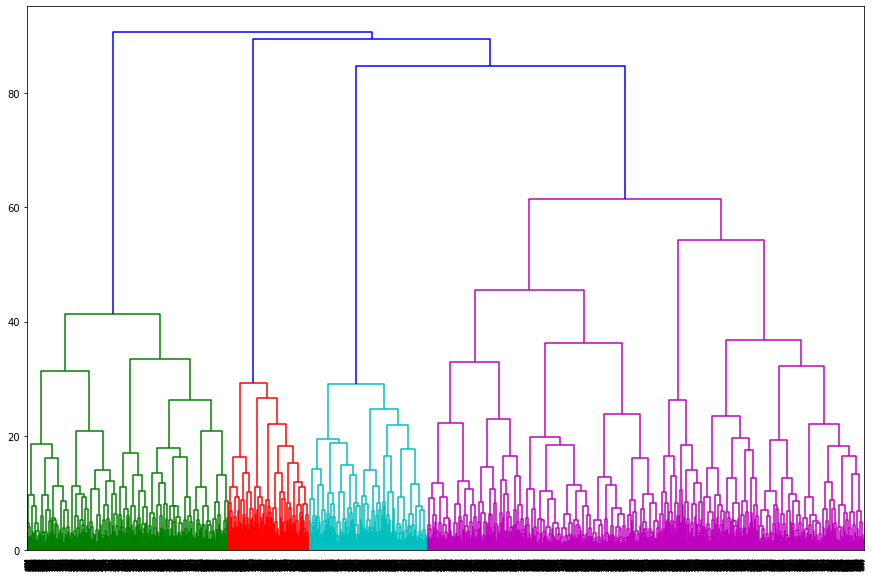

In [15]:
# построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top');

Судя по дендрограмме, клиентов можно разделить на 5 кластеров. Сделаем это на основании алгоритма K-Means.

In [16]:
# обучим модель кластеризации и спрогнозируем кластеры клиентов
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

In [17]:
# посмотрим на средние значения признаков по кластерам
df['cluster_km'] = labels
round(df.drop(columns=['churn']).groupby(['cluster_km']).mean(), 2).reset_index().style.background_gradient('Blues')

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month
0,0,0.49,1,0.22,0.07,1,2.04,0.29,27.67,117.18,1.95,1.18
1,1,0.5,1,0.89,1,1,6.91,0.52,29.6,153.36,4.28,1.92
2,2,0.52,0.86,0.47,0.31,0,4.78,0.43,29.3,144.21,3.94,1.72
3,3,0.5,0,0.49,0.08,1,2.99,0.23,28.68,137.13,2.97,1.6
4,4,0.55,1,0.38,0.01,1,6.21,0.53,30.63,179,5.41,2.35


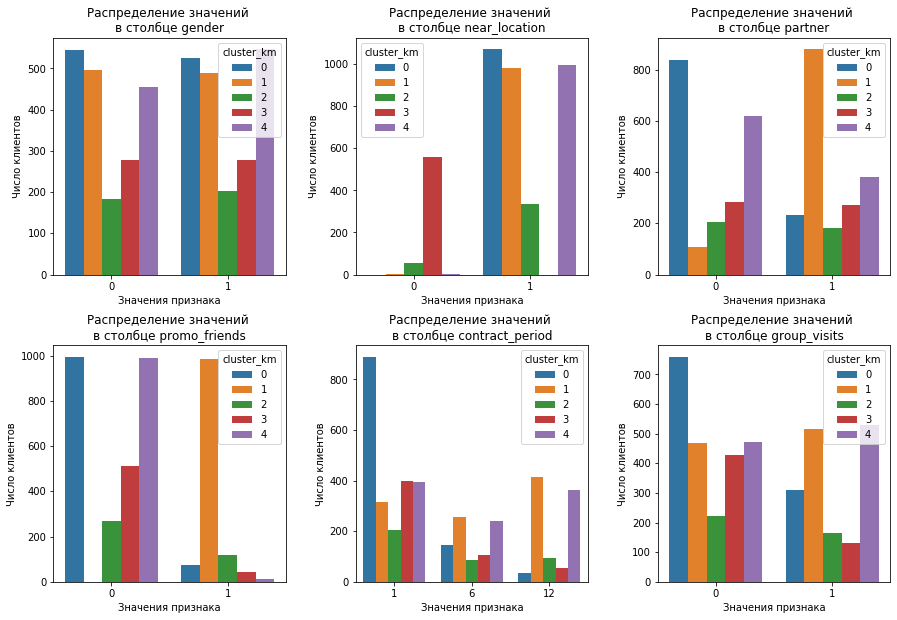

In [18]:
# построим столбчатые диаграммы для бинарных признаков
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(['gender', 'near_location', 'partner', 'promo_friends', 'contract_period', 'group_visits']):
    ax = fig.add_subplot(2, 3, i+1)
    sns.countplot(x = df[col], hue='cluster_km', data=df)
    ax.set_title('Распределение значений \nв столбце {}'.format(col))
    ax.set_xlabel('Значения признака')
    ax.set_ylabel('Число клиентов')
plt.subplots_adjust(wspace=0.3, hspace=0.3);

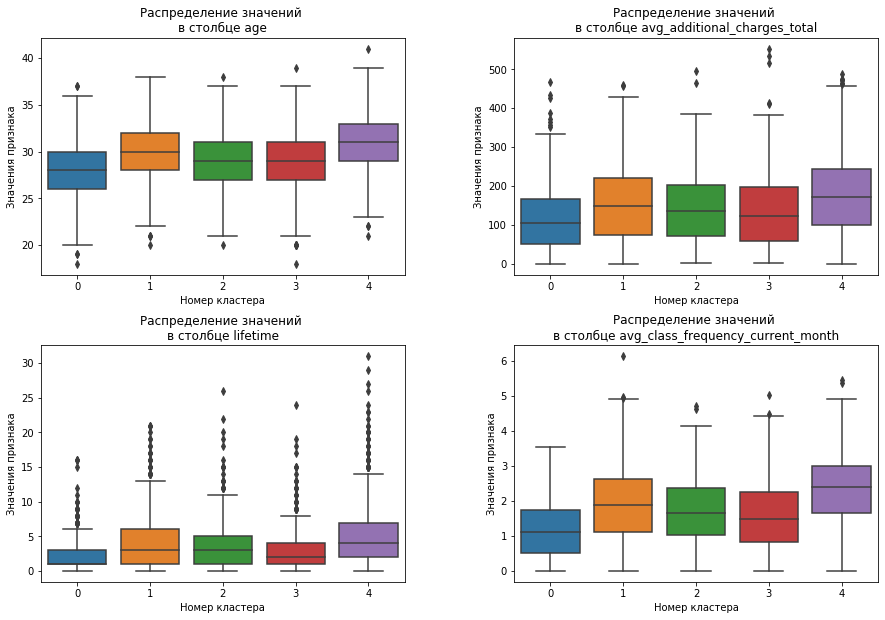

In [19]:
# построим диаграммы размаха для численных признаков 
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']):
    ax = fig.add_subplot(2, 2, i+1)
    sns.boxplot(x = 'cluster_km', y = df[col], data = df)
    ax.set_title('Распределение значений \nв столбце {}'.format(col))
    ax.set_ylabel('Значения признака')
    ax.set_xlabel('Номер кластера')
plt.subplots_adjust(wspace=0.3, hspace=0.3);

По результатам кластеризации выделены следующие группы клиентов:
1. В первый кластер входят самые молодые клиенты (средний возраст 28 лет), которые тратят меньше остальных денег на дополнительные услуги (117,18 у.е.), не очень охотно посещают групповые занятия (29%), берут краткосрочные абонементы (средний срок - 2 месяца), что соответствует их низкой лояльности сети (средний lifetime - около 2 месяцев, среднее количество тренировок в неделю - 1). В данном кластере самый низкий процент партнёрских клиентов, что объясняет короткий срок контракта: корпоративные абонементы обычно покупают на год. По реферальной программе пришли 7% пользователей.
2. Средний возраст клиентов во втором кластере составляет 29 с половиной лет, у них самые долгие абонементы (средний срок больше полугода), 89% из них корпоративные, и 100% клиентов пришли по приглашению друзей. Они активно ходят на групповые занятия (52%) и стабильно посещают индивидуальные тренировки (среднее значение - 1,92 раза в неделю).
3. Клиентов третьего кластера объединяет тот факт, что никто из них не оставил свой контактный телефон. Средний возраст группы достаточно высокий - 29 лет, 14% живут далеко от зала, 47% имеют корпоративный абонемент, 31% пришли по акции "Приведи друга", 43% ходят на групповые тренировки, средний lifetime около 4 месяцев.
4. В четвёртый кластер попали клиенты, которые живут и работают далеко от фитнес-центра, поэтому редко ходят на тренировки, как групповые (23%), так и индивидуальные (1,6 раз в неделю), и быстро их бросают. Средний возраст этих клиентов - 28 с половиной лет. Средняя длительность абонемента соответствует "сроку жизни" клиента - 3 месяца.
5. В пятый кластер входят клиенты с самым высоким средним возрастом (30 с половиной лет), которые часто ходят на групповые тренировки (52%), покупают долгосрочные абонементы (средний срок - полгода) и активно приобретают дополнительные услуги (каждый клиент дополнительно приносит в среднем 179 у.е.). Они также чаще остальных ходят в зал (2,35 тренировок в текущем месяце) и лояльны сети (средний lifetime - 5,4 месяцев). 38% имеют корпоративные абонементы, но только 1% пришёл по приглашению друзей.

Вероятно, комбинация вышеуказанных факторов - возраст клиента, удобство расположения зала, наличие корпоративного абонемента, участие в реферальной программе - прямо влияет на посещение тренировок и удержание клиента в сети. Проверим уровень оттока по кластерам.

In [20]:
df.groupby('cluster_km').agg({'churn':'mean'}).reset_index().style.background_gradient('coolwarm')

,cluster_km,churn
0,0,0.558879
1,1,0.119675
2,2,0.266839
3,3,0.403226
4,4,0.017


Самый высокий отток во первом (56%) и четвёртом (40%) кластерах, т.е. среди молодых клиентов, которые редко посещают групповые занятия, покупают краткосрочные абонементы до 3 месяцев, не участвуют в программе "Пригласи друга" и либо далеко живут, либо не имеют корпоративных скидок, что снижает их мотивацию продолжать заниматься. Самый низкий уровень оттока (всего 2%) зафиксирован в пятом кластере (люди старше 30, которые живут или работают поблизости от зала, часто ходят на тренировки и покупают долгосрочные абонементы от полугода), также низкий отток (12%) во втором кластере пришедших по реферальной программе и имеющих партнёрский абонемент. В третьем кластере отток в 27%, возможно, вызван неудобством расположения зала, по остальным характеристикам этот кластер близок к двум самым лояльным. Подводя итог, портрет идеального клиента сети "Культурист-датасаентист": мужчина или женщина старше 29 лет, живущие или работающие неподалёку, пришедшие по приглашению друга или по программе корпоративного фитнеса, которые активно посещают групповые тренировки. Вероятность оттока при сочетании всех этих факторов будет крайне низкой.

## Общий вывод

В данном исследовании мы проанализировали 4000 анкет клиентов сети фитнес-центров «Культурист-датасаентист» и выявили следующие особенности:
1. Половая принадлежность клиентов не оказывает никакого влияния на факт оттока;
2. Сильнее всего с оттоком связаны возраст клиента (чем он моложе, тем больше вероятность ухода), активность посещений в последний месяц (если человек внезапно перестал ходить, скорее всего, он уже не вернется) и длительность абонемента (контракт на 1 или 3 месяца после завершения часто не продляют).
3. На отток также влияют наличие корпоративного абонемента, участие в программе "Приведи друга", удобство расположения зала и посещение групповых занятий.

На основе данных мы создали две модели бинарной классификации для предсказания вероятности оттока клиента в следующем месяце. Протестировав их на валидационной выборке, получили такие значения метрик: 
- для модели логистической регрессии:
    - Accuracy: 0.90, 
    - Precision: 0.79, 
    - Recall: 0.82, 
    - F1: 0.81, 
    - ROC_AUC: 0.96; 
- для модели случайного леса: 
    - Accuracy: 0.90, 
    - Precision: 0.81, 
    - Recall: 0.75, 
    - F1: 0.78, 
    - ROC_AUC: 0.95. 

Доля правильных ответов (accuracy) двух моделей одинакова, поэтому в зависимости от целей можно использовать любую из них: для удержания как можно большего числа клиентов модель логистической регрессии подходит лучше (выше полнота обнаружения объектов целевого класса (recall) и сводные метрики F1-score и ROC_AUC), однако если компания опасается раздражать клиентов агрессивным маркетингом и ценит точность предсказаний, следует использовать случайный лес (точность предсказаний в целевом классе (precision) у него выше).

Мы также разбили клиентов на 5 кластеров с помощью алгоритма K-Means и получили несколько характерных групп:
1. Клиенты с высоким средним возрастом (30 с половиной лет), которые часто ходят на групповые тренировки (52%), покупают долгосрочные абонементы (средний срок - полгода) и активно приобретают дополнительные услуги (каждый клиент дополнительно приносит в среднем 179 у.е.). Они также чаще остальных ходят в зал (2,36 тренировки в текущем месяце) и лояльны сети (средний lifetime - 5,4 месяцев). 38% имеют корпоративные абонементы. Среди них самый низкий уровень оттока - всего 2%.
2. Самые молодые клиенты (средний возраст 28 лет), которые тратят мало денег на дополнительные услуги (117,18 у.е.), не очень охотно посещают групповые занятия (29%), берут краткосрочные абонементы (средний срок - 2 месяца), что соответствует их низкой лояльности сети (средний lifetime - около 2 месяцев, среднее количество тренировок в неделю - 1). В данном кластере самый низкий процент партнёрских абонементов и самый высокий уровень оттока - 56%.
3. Клиенты, которые живут и работают далеко от фитнес-центра, поэтому редко ходят на тренировки, как групповые (23%), так и индивидуальные (1,6 раз в неделю), и быстро их бросают. Средний возраст этих клиентов - 28 с половиной лет. Средняя длительность абонемента соответствует "сроку жизни" клиента - 3 месяца, величина оттока - 40%.
4. Клиенты, которые пришли по приглашению друзей, возрастом от 29 с половиной лет и старше с самыми долгими абонементами (средний срок больше полугода), 89% из которых корпоративные. Отток в данном кластере составляет 12%.
5. Клиенты, которые отказались оставлять свой контактный телефон. Средний возраст группы достаточно высокий - 29 лет, 14% живут далеко от зала, 47% имеет корпоративный абонемент, 31% пришли по акции "Приведи друга", 43% ходят на групповые тренировки, средний lifetime около 4 месяцев. Отток в данном кластере составляет 27%.

Данные по кластерам подтвердили предположение, что на отток сильно всего влияют возраст, длительность абонемента, участие в корпоративных программах или акции "Приведи друга" и удобство расположения зала. С учётом этого мы можем дать следующие рекомендации:
1. Целевая группа клиентов - люди старше 30 лет, которые живут или работают неподалёку от центра, поэтому на них нужно делать упор в рекламной кампании;
2. Более молодых клиентов можно привлекать через акцию "Приведи друга" и корпоративный фитнес, поэтому стоит расширить партнёрскую сеть среди работодателей и сделать привлекательными условия реферальной программы как для пригласившего, так и для приглашённого;
3. Данные показывают, что факт посещения групповых тренировок положительно сказывается на удержании клиента, поэтому нужно составить удобное расписание занятий и активно рекламировать клиентам этот вид услуг;
4. Также рекомендуем снизить цены долгих контрактов, чтобы мотивировать клиентов покупать абонементы сроком от полугода и выше: в долгосрочной перспективе их лояльность окупится.